### Import Libraries

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
! pip install pyspark;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317146 sha256=f296484ada9f9d15b578e768daa3d35060d36a26cda655e0e8983644a866e3c9
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import desc, col, size, udf, countDistinct, round, count
from pyspark.sql.types import *

In [4]:
MAX_MEMORY = "3G"

conf = pyspark.SparkConf().setMaster("local[*]") \
        .set("spark.executor.heartbeatInterval", 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)

def init_spark():
    return SparkSession \
            .builder \
            .appName("Indian Restaurants EDA Pyspark") \
            .config(conf=conf) \
            .getOrCreate()


spark = init_spark()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/13 14:09:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Import Dataset

In [5]:
schema = StructType([
    StructField("Name", StringType()),
    StructField("Location", StringType()),
    StructField("Locality", StringType()),
    StructField("City", StringType()),
    StructField("Cuisine", StringType()),
    StructField("Rating", FloatType()),
    StructField("Votes", IntegerType()),
    StructField("Cost", IntegerType()),
])

In [6]:
df = spark.read.schema(schema).csv("/kaggle/input/indian-restaurants-2023/restaurants.csv", header=True)
type(df)

pyspark.sql.dataframe.DataFrame

In [7]:
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Locality: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Cuisine: string (nullable = true)
 |-- Rating: float (nullable = true)
 |-- Votes: integer (nullable = true)
 |-- Cost: integer (nullable = true)



In [8]:
df.limit(3).toPandas()

,Name,Location,Locality,City,Cuisine,Rating,Votes,Cost
0,Local,"Scindia House,Connaught Place, Central Delhi",Central Delhi,Delhi,"North Indian, Finger Food, Continental",4.1,2415,2000
1,The G.T. ROAD,"M-Block,Connaught Place, Central Delhi",Central Delhi,Delhi,North Indian,4.3,2363,1500
2,Tamasha,"Connaught Place, Central Delhi",Central Delhi,Delhi,"Finger Food, North Indian, Italian, Contine...",4.2,5016,2000


### Find Missing Values

In [9]:
str_col = ["Name", "Location", "Locality", "City", "Cuisine"]
num_col = ["Votes", "Cost"]
missing_values = {}

for column in df.columns :
    if column in str_col :
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        # eqNullSafe(): Equality test that is safe for null values.
        missing_values.update({column:missing_count})
        
    if column in num_col :
        missing_count = df.filter(col(column).isin([np.nan]) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
        
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,Name,Location,Locality,City,Cuisine,Votes,Cost
0,0,0,0,0,0,0,0


### Utility Functions

In [10]:
def plot_bar(data, labels, xlabel, title):
    fig = plt.figure(figsize=[11,4])
    ax = fig.gca()
    colors = ["#f9cdac","#f2a49f","#ec7c92","#e65586","#bc438b","#933291","#692398","#551c7b","#41155e","#2d0f41"]
    plt.barh(labels, data, color=colors)
    plt.xlabel(xlabel)
    for i, v in enumerate(data):
        ax.text(v+0.5, i, str(v), color='#424242')
    plt.title(title)
    plt.show()    

In [11]:
def plot_pie(data, labels, legend_title, title):
    fig = plt.figure(figsize=(10,5))
    ax = fig.gca()
    # Creating autocpt arguments
    def func(pct):
        return "{:.1f}%".format(pct)

    colors = ["#f9cdac","#f2a49f","#ec7c92","#e65586","#bc438b","#933291","#692398","#551c7b","#41155e","#2d0f41"]
    wedges, texts, autotexts = ax.pie(x=data, autopct=lambda pct : func(pct))

    ax.legend(wedges, labels,
              title = legend_title,
              loc ="center left",
              bbox_to_anchor =(1.2, 0, 0.5, 1))
    plt.setp(autotexts, size = 8, weight ="normal")
    plt.title(title)
    plt.show()    

### Explolatory Data analysis 

#### Top 5 Expensive Restaurants In India

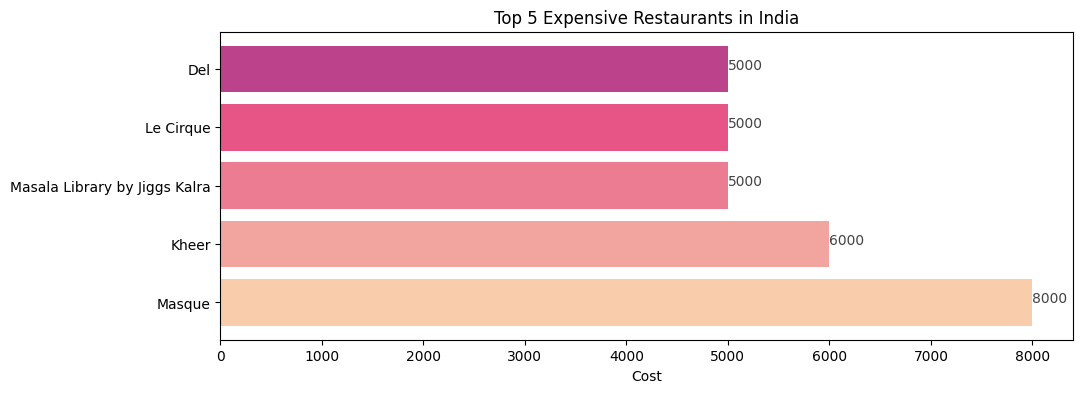

In [12]:
top_expensive_restro = df.sort(col("Cost").desc()).limit(5).toPandas()
plot_bar(top_expensive_restro.Cost.values, top_expensive_restro.Name.values, "Cost", "Top 5 Expensive Restaurants in India")

#### Restaurants with Maximum Rating and Popularity By City

In [13]:
city_list = [city[0] for city in df.dropDuplicates(["City"]).select("City").toPandas().values.tolist()]
for i, city in enumerate(city_list) :
    if i % 12 == 0 : print()
    print(city, end=",\t")


Bangalore,	Udaipur,	Kochi,	Vadodara,	Chennai,	Lucknow,	Mumbai,	Goa,	Ahmedabad,	Kolkata,	Noida,	Ludhiana,	
Gurgaon,	Surat,	Agra,	Pune,	Delhi,	Chandigarh,	Nagpur,	Ghaziabad,	Hyderabad,	Indore,	Jaipur,	

In [14]:
city_input = "Mumbai"

In [15]:
popular_restro = df.filter(col("City") == city_input).sort(col("Votes").desc()).limit(10).toPandas()

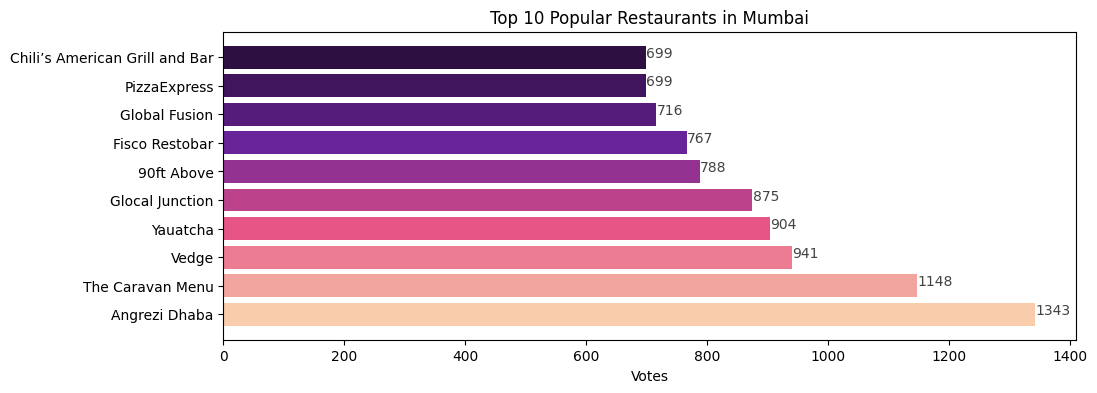

In [16]:
plot_bar(popular_restro.Votes.values, popular_restro.Name.values, "Votes", "Top 10 Popular Restaurants in "+city_input)

In [17]:
threshold_votes = 20
rating_restro = df.filter(col("City") == city_input).filter(col("Votes")>threshold_votes)\
    .sort(col("Rating").desc(), desc(col("Votes"))).limit(10).toPandas()

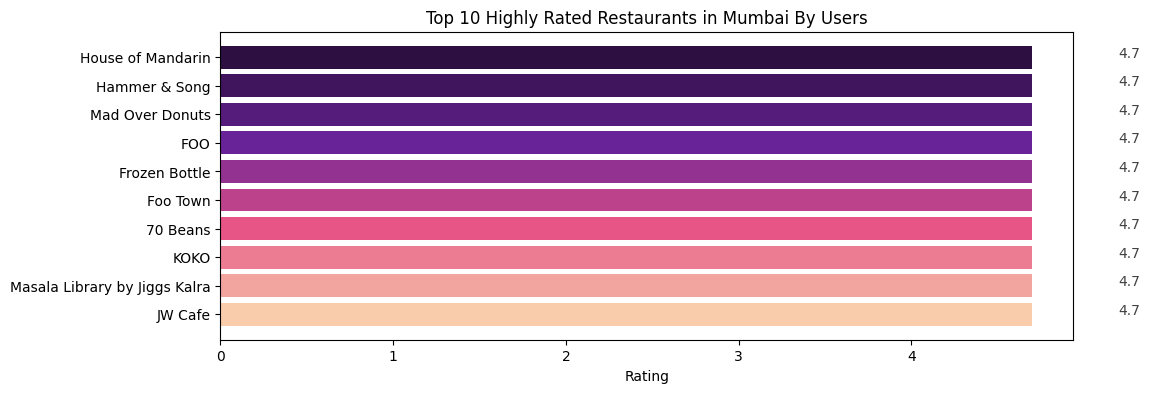

In [18]:
plot_bar(rating_restro.Rating.values, rating_restro.Name.values, "Rating", "Top 10 Highly Rated Restaurants in "+city_input+" By Users")

#### Relation Between Average Cost And Rating

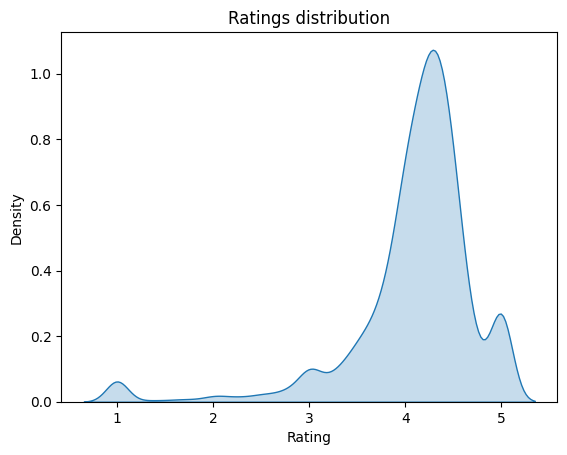

In [19]:
sns.kdeplot(df.toPandas()["Rating"], fill=True)
plt.title("Ratings distribution")
plt.show()

On average majority of restaurants have rating between 3.5 to 4.5

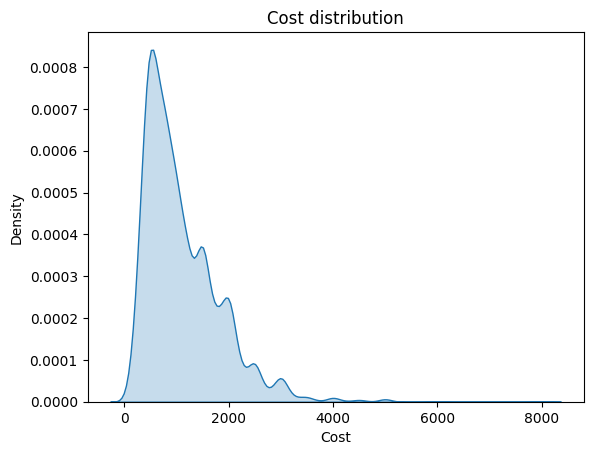

In [20]:
sns.kdeplot(df.toPandas()["Cost"], fill=True)
plt.title("Cost distribution")
plt.show()

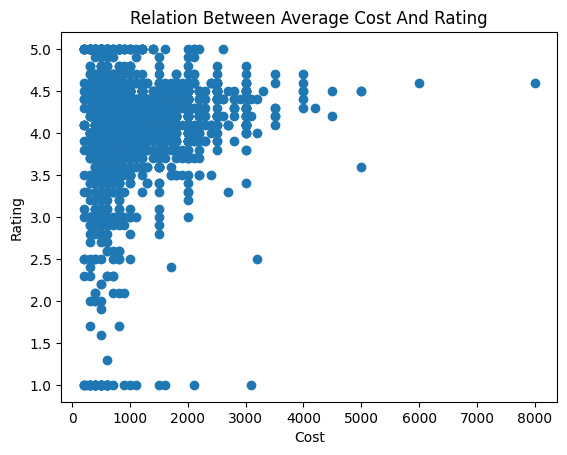

In [21]:
plt.plot("Cost", "Rating", data=df.toPandas().sample(2000), linestyle="none", marker="o")
plt.xlabel("Cost")
plt.ylabel("Rating")
plt.title("Relation Between Average Cost And Rating")
plt.show()

In [22]:
def price_range_round(val):    
    if val <= 1000 :
        return 1
    elif 1000 < val <= 2000 :
        return 2
    elif 2000 < val <= 3000 :
        return 3
    elif 3000 < val <= 4000 :
        return 4
    elif 4000 < val <= 5000 :
        return 5
    elif 5000 < val <= 6000 :
        return 6
    elif 6000 < val <= 7000 :
        return 7
    elif 7000 < val <= 8000 :
        return 8    

udf_price_range = udf(lambda val : price_range_round(val))
df = df.withColumn("price_range",udf_price_range("Cost"))
df.toPandas().head(3)

,Name,Location,Locality,City,Cuisine,Rating,Votes,Cost,price_range
0,Local,"Scindia House,Connaught Place, Central Delhi",Central Delhi,Delhi,"North Indian, Finger Food, Continental",4.1,2415,2000,2
1,The G.T. ROAD,"M-Block,Connaught Place, Central Delhi",Central Delhi,Delhi,North Indian,4.3,2363,1500,2
2,Tamasha,"Connaught Place, Central Delhi",Central Delhi,Delhi,"Finger Food, North Indian, Italian, Contine...",4.2,5016,2000,2


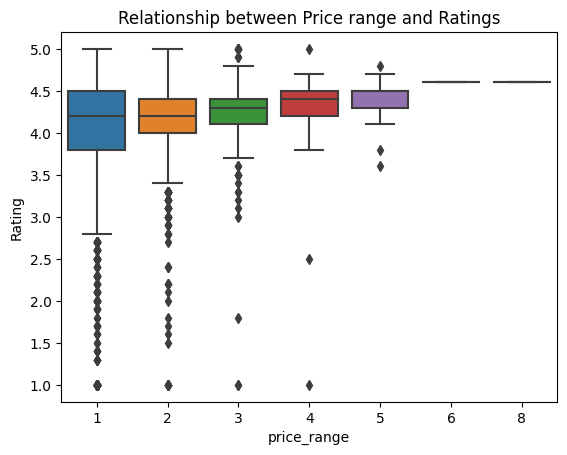

In [23]:
sns.boxplot(x="price_range", y="Rating", data=df.toPandas().sort_values(by=["price_range"]))
plt.title("Relationship between Price range and Ratings")
plt.show()

This concludes that as the average cost increases, there is a high probablity that the restaurant will be highly rated.


#### Restaurants with Maximum Outlets

In [24]:
top_outlets = df.groupBy(col("Name")).agg(count(col("Name")).alias("name_count"))\
    .filter(col("name_count")>1).sort(desc(col("name_count"))).limit(10).toPandas()
top_outlets.head(3)

,Name,name_count
0,Wow! Momo,67
1,Kanti Sweets,65
2,Barbeque Nation,48


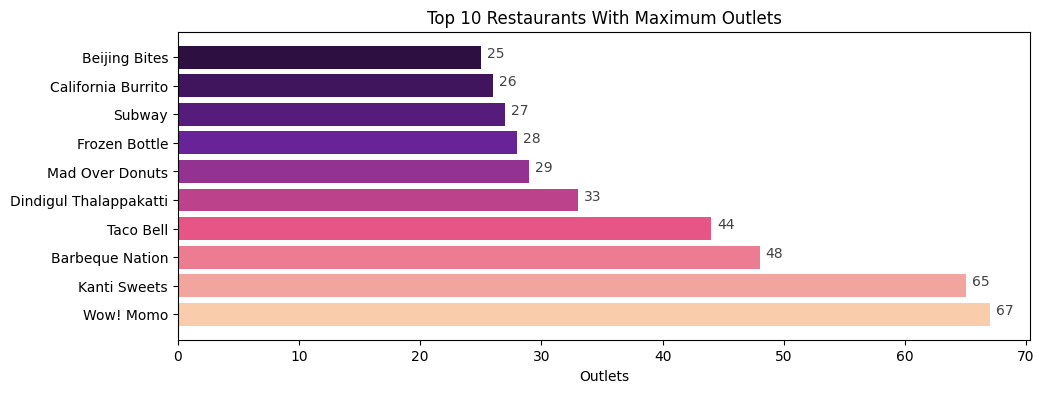

In [25]:
plot_bar(top_outlets.name_count.values, top_outlets.Name.values, "Outlets", "Top 10 Restaurants With Maximum Outlets")

In [26]:
outlet_input = "Mad Over Donuts"

In [27]:
outlet_destri_cities = df.filter(col("Name")==outlet_input).groupBy(col("City")).agg(count(col("City")).alias("city_count")).toPandas()
outlet_destri_cities.head()

,City,city_count
0,Bangalore,2
1,Mumbai,23
2,Delhi,4


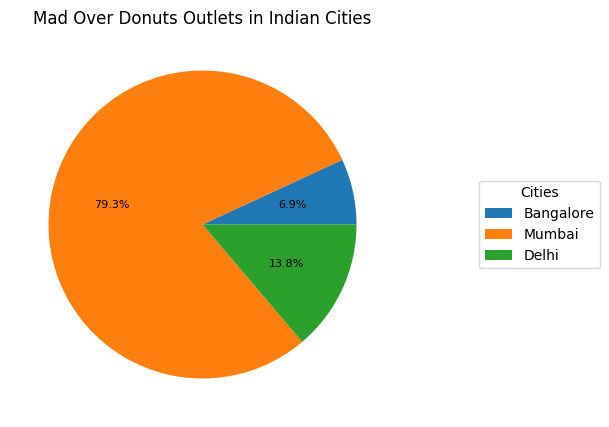

In [28]:
plot_pie(outlet_destri_cities.city_count.values.tolist(), outlet_destri_cities.City.values.tolist(), "Cities", outlet_input+" Outlets in Indian Cities")

In [29]:
outlet_destri_locality = df.filter(col("City")==city_input).filter(col("Name")==outlet_input).groupBy(col("locality"))\
    .agg(count(col("locality")).alias("locality_count")).toPandas()
outlet_destri_locality.head(3)

,locality,locality_count
0,Andheri West,2
1,South Mumbai,3
2,Thane,1


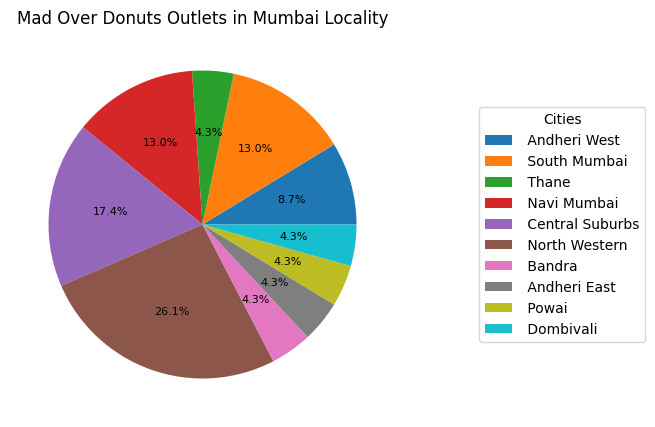

In [30]:
plot_pie(outlet_destri_locality.locality_count.values.tolist(), outlet_destri_locality.locality.values.tolist(), "Cities", \
            outlet_input+" Outlets in "+city_input+" Locality")

#### Popular Cuisines By City

In [31]:
cuisines = []
def format_cuisine(line):
    cuisine_list = line.split(",")
    for cuisine in cuisine_list :
        cuisine = cuisine.strip()
        if cuisine not in cuisines : cuisines.append(cuisine)
            
for line in df.select("Cuisine").collect():
    format_cuisine(line.Cuisine)

In [32]:
cuisines_count = {cuisine:0 for cuisine in cuisines }
df_cuisines_list = df.filter(col("City")==city_input).select("Cuisine").rdd.flatMap(lambda x : x).collect()

In [33]:
for row in df_cuisines_list :
    cuisine_list = row.split(", ")
    for cuisine in cuisine_list :
        if cuisine == "Multi-Cuisine" : continue
        cuisine = cuisine.strip()  
        cuisines_count[cuisine] += 1 
        
cuisines_count = dict(sorted(cuisines_count.items(), key= lambda x: x[1], reverse=True))
for i, (key, val) in enumerate(cuisines_count.items()):
    print(key, val)
    if i == 4 : break

North Indian 335
Chinese 280
Fast Food 197
Continental 181
Italian 178


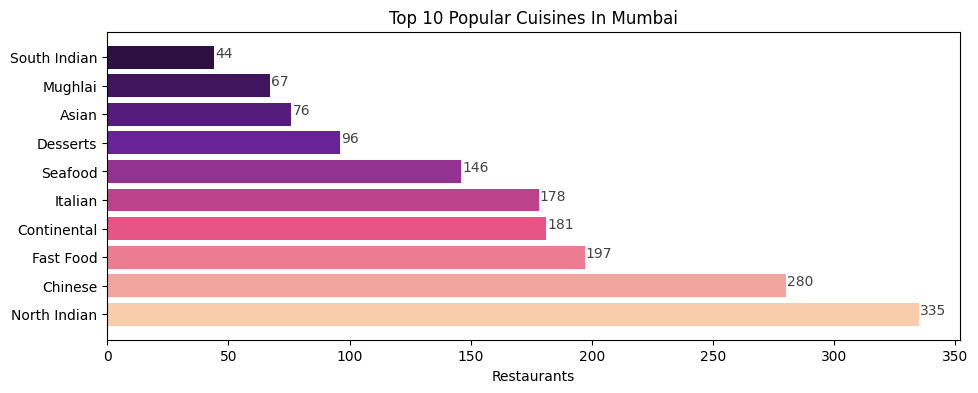

In [34]:
plot_bar(list(cuisines_count.values())[:10], list(cuisines_count.keys())[:10], "Restaurants", "Top 10 Popular Cuisines In "+city_input)

#### Popular Restaurants With A Particular Cuisine

In [35]:
for i, cuisine in enumerate(cuisines) :
    if i % 12 == 0 : print()
    print(cuisine, end=",\t")


North Indian,	Finger Food,	Continental,	Italian,	Asian,	Mediterranean,	Oriental,	Mexican,	American,	Multi-Cuisine,	Chinese,	Seafood,	
Rajasthani,	Fusion,	South Indian,	Mughlai,	Modern Indian,	Japanese,	World Cuisine,	Fast Food,	European,	Tex Mex,	Thai,	Korean,	
Barbecue,	Andhra,	Biryani,	Street Food,	Coffee,	Hyderabadi,	Tea,	Gujarati,	Desserts,	Ice Cream,	Shakes,	Bakery and Confectionary,	
Pizza,	Sushi,	Indian Cuisine,	Sizzlers,	Spanish,	Waffle,	Lebanese,	Kerala,	Goan,	Kashmiri,	French,	Tibetan,	
Health Food,	Indonesian,	Mithai,	South American,	Arabian,	Deli,	Middle Eastern,	Doughnuts,	Burger,	Nepalese,	Malaysian,	North Eastern,	
Naga,	Turkish,	Juice,	Bengali,	Bihari,	Chettinad,	Singaporean,	Iranian,	Vietnamese,	Lucknowi,	African,	Portuguese,	
Greek,	Moroccan,	Mangalorean,	Coastal,	Awadhi,	Malvani,	British,	Maharashtrian,	Parsi,	Burmese,	Assamese,	Cantonese,	
Sindhi,	Drinks,	Yogurt,	Konkani,	Chaat,	Persian,	Pakistani,	Contemporary Continental,	Afghani,	Western,	North West Frontier,	Ge

In [36]:
cuisine_input = "North Indian"

In [37]:
popular_cuisines = df.filter(col("City") == city_input).filter(df.Cuisine.contains(cuisine_input)).sort(desc(col("Votes")), desc(col("Rating")))
top = popular_cuisines.count() if popular_cuisines.count() < 10 else 10
top_popular_cuisines = popular_cuisines.limit(top).toPandas()

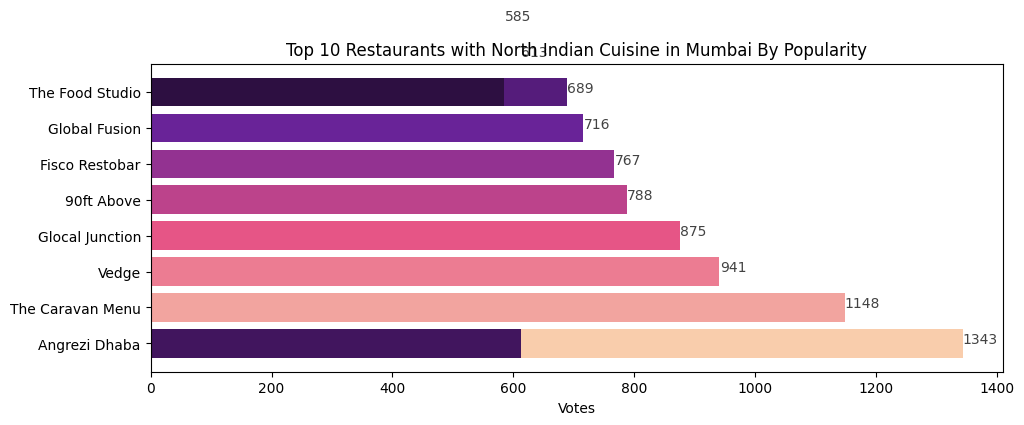

In [38]:
plot_bar(top_popular_cuisines.Votes.values, top_popular_cuisines.Name.values, "Votes", \
            "Top "+str(top)+" Restaurants with "+cuisine_input+" Cuisine in "+city_input+" By Popularity")

In [39]:
threshold_votes = 20
rating_cuisines = df.filter(col("City") == city_input).filter(col("Votes")>threshold_votes)\
    .filter(df.Cuisine.contains(cuisine_input)).sort(desc(col("Rating")), desc(col("Votes")))
top = rating_cuisines.count() if rating_cuisines.count() < 10 else 10
top_rating_cuisines = rating_cuisines.limit(top).toPandas()

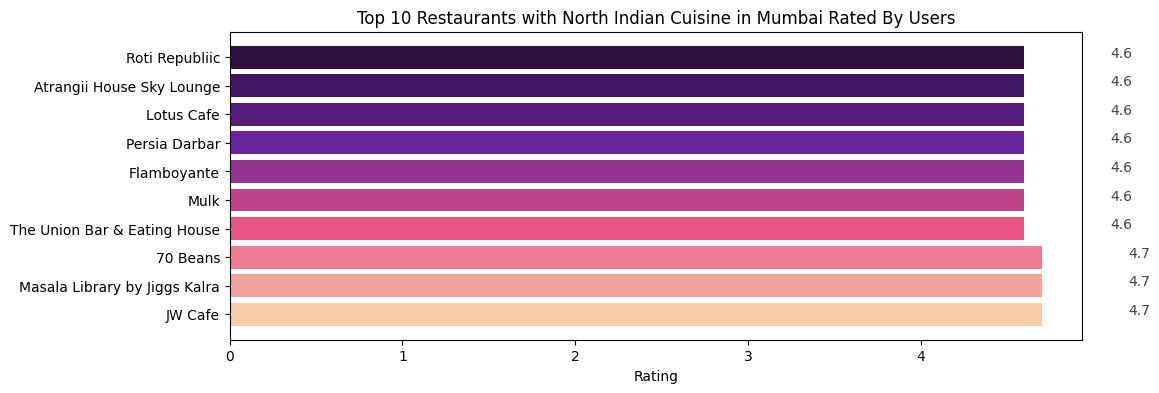

In [40]:
plot_bar(top_rating_cuisines.Rating.values, top_rating_cuisines.Name.values, "Rating", \
         "Top "+str(top)+" Restaurants with "+cuisine_input+" Cuisine in "+city_input+" Rated By Users")

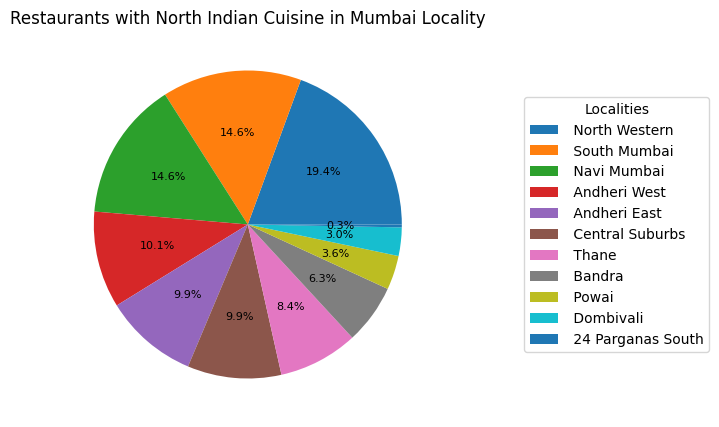

In [41]:
plot_pie(popular_cuisines.toPandas().Locality.value_counts().values.tolist(), popular_cuisines.toPandas().Locality.value_counts().index.tolist(),\
        "Localities", "Restaurants with "+cuisine_input+" Cuisine in "+city_input+" Locality")